In [2]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [3]:
#Загрузим данные
data = pd.read_csv('data_eda.csv')

In [4]:
#Выделим целевой признак и фичи
X = data.drop(columns = ['IC50, mM','CC50, mM','SI'])
y = data.loc[:,['IC50, mM']]

In [5]:
# Получим тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
#Расчитаем медианы для задач классификации
IC_med = y_train['IC50, mM'].median()
y_train['IC_med'] = y_train['IC50, mM']>IC_med
y_test['IC_med'] = y_test['IC50, mM']>IC_med
y_train = y_train['IC_med'].astype(int)
y_test = y_test['IC_med'].astype(int)

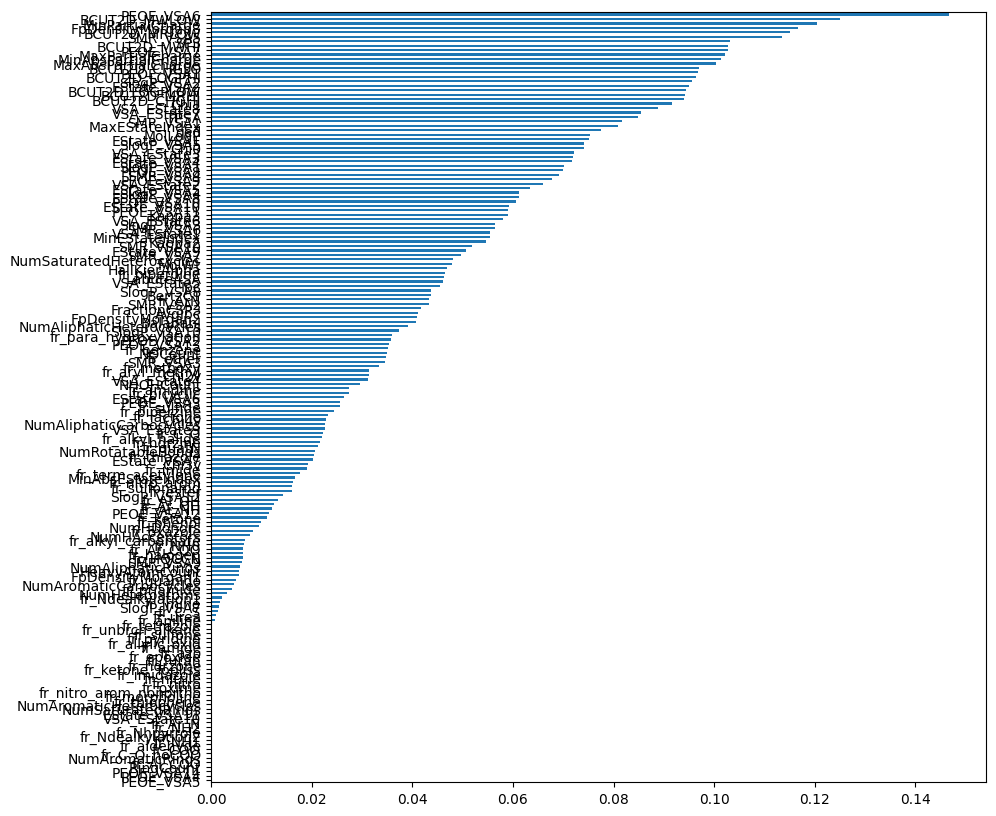

In [7]:
#Воспользуемся mutual_info_classif для feature selection
mutual = mutual_info_classif(X_train, y_train)
main_features = pd.Series(mutual, X_train.columns[0:len(X_train.columns)])
main_features = main_features.sort_values()
plt.figure(figsize=(10,10))
main_features.plot(kind='barh')
plt.show()

In [8]:
# После всех экспериментов оставим только 25 лучших признаков
selector = SelectKBest(mutual_info_classif, k=25)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

In [9]:
#Выполним масштабирование признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_sel)
X_test = scaler.transform(X_test_sel)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

<Axes: >

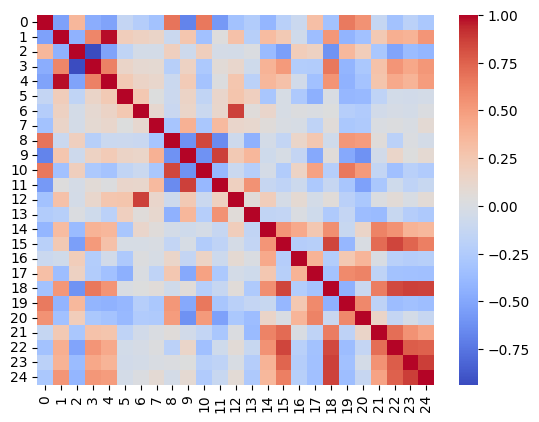

In [10]:
#Посмотрим, сколько высококореллированных признаков осталось после Feature_sel
sns.heatmap(X_train.corr(), cmap = 'coolwarm')

In [11]:

corr_mat = X_train.corr()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col].abs()>0.9)]
print(f'Высококореллированные признаки: {high_corr}')

Высококореллированные признаки: [3, 4]


In [12]:
#Удалим высококореллированные признаки
X_train = X_train.drop(columns = [4])
X_test = X_test.drop(columns = [4])

In [13]:
#Создадим словарик с моделями перед BayesSearch
models = {
    "DecisionTree": (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': (2, 21),
        'min_samples_split': (2, 11),
        'min_samples_leaf': (2, 11),
    }),
    "RandomForest": (RandomForestClassifier(), {
        'n_estimators': (50, 500),
        'criterion': ['gini', 'entropy'],
        'max_depth': (1, 50),
        'min_samples_split': (2, 25),
        'min_samples_leaf': (2, 11),
        'max_features': ['sqrt', 'log2', None],
    }),
    "KNN": (KNeighborsClassifier(), {
        'n_neighbors': (1, 21),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }),
    "LogisticRegression": (LogisticRegression(solver='liblinear', max_iter=1000), {
        'penalty': ['l1', 'l2'],
        'C': (0.01, 100.0, 'log-uniform'),
        'fit_intercept': [True, False],
        'class_weight': [None, 'balanced']
    }),
    "SVC": (SVC(), {
        'C': (0.1, 100.0, 'log-uniform'),
        'kernel': ['linear', 'rbf', 'poly'], 
        'gamma': (0.001, 1.0, 'log-uniform'),
        'degree': (2, 5),
        'class_weight': [None, 'balanced']
    }),
    "XGBoost_Classifier": (XGBClassifier(), {
        'n_estimators': (100, 1000),
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'max_depth': (3, 10),
        'subsample': (0.6, 1.0, 'uniform'),
        'colsample_bytree': (0.6, 1.0, 'uniform'),
        'gamma': (0, 5, 'uniform'),
        'reg_alpha': (0, 1.0, 'uniform'),
        'reg_lambda': (0, 1.0, 'uniform'),
    }),
    "LightGBM_Classifier": (LGBMClassifier(), {
        'n_estimators': (100, 1000),
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'max_depth': (3, 10),             
        'num_leaves': (20, 150),
        'subsample': (0.6, 1.0, 'uniform'),
        'colsample_bytree': (0.6, 1.0, 'uniform'),
        'reg_alpha': (0, 1.0, 'uniform'),
        'reg_lambda': (0, 1.0, 'uniform'),
    })
}
# Перебор моделей
all_models_results = {}

for name, (model, params) in models.items():
    print(f"Обучаем {name}...")

    # Байесовская оптимизация гиперпараметров
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=params,
        n_iter=50,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Обучение модели
    bayes_search.fit(X_train, y_train)

    all_models_results[name] = {
        "best_params": bayes_search.best_params_,
        "best_score": bayes_search.best_score_,
        "best_model": bayes_search.best_estimator_
    }

    print(f"{name} - Accuracy: {bayes_search.best_score_:.4f}")

Обучаем DecisionTree...
DecisionTree - Accuracy: 0.6902
Обучаем RandomForest...
RandomForest - Accuracy: 0.7242
Обучаем KNN...


C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of s

KNN - Accuracy: 0.7007
Обучаем LogisticRegression...
LogisticRegression - Accuracy: 0.6588
Обучаем SVC...
SVC - Accuracy: 0.7124
Обучаем XGBoost_Classifier...
XGBoost_Classifier - Accuracy: 0.7216
Обучаем LightGBM_Classifier...
[LightGBM] [Info] Number of positive: 382, number of negative: 383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4759
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499346 -> initscore=-0.002614
[LightGBM] [Info] Start training from score -0.002614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [14]:
all_models_results.items()

dict_items([('DecisionTree', {'best_params': OrderedDict({'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 7, 'min_samples_split': 11}), 'best_score': np.float64(0.6901960784313725), 'best_model': DecisionTreeClassifier(criterion='entropy', max_depth=19, min_samples_leaf=7,
                       min_samples_split=11)}), ('RandomForest', {'best_params': OrderedDict({'criterion': 'gini', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}), 'best_score': np.float64(0.7241830065359476), 'best_model': RandomForestClassifier(max_depth=18, max_features='log2', min_samples_leaf=2,
                       n_estimators=500)}), ('KNN', {'best_params': OrderedDict({'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}), 'best_score': np.float64(0.7006535947712418), 'best_model': KNeighborsClassifier(n_neighbors=10, p=1)}), ('LogisticRegression', {'best_params': OrderedDict({'C': 2.280564064578319, 'class_weight': 'balanced', 'fit_int

In [15]:
for model, best_model in all_models_results.items():
    print(f'Результаты {model} на отложенной выборке:')
    y_pred = best_model['best_model'].predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    print(f'Accuracy для модели {model}: {acc}')
    print(f'Precision для модели {model}: {prec}')
    print(f'Recall для модели {model}: {rec}')

Результаты DecisionTree на отложенной выборке:
Accuracy для модели DecisionTree: 0.6302083333333334
Precision для модели DecisionTree: 0.673469387755102
Recall для модели DecisionTree: 0.6285714285714286
Результаты RandomForest на отложенной выборке:
Accuracy для модели RandomForest: 0.6979166666666666
Precision для модели RandomForest: 0.7373737373737373
Recall для модели RandomForest: 0.6952380952380952
Результаты KNN на отложенной выборке:
Accuracy для модели KNN: 0.6666666666666666
Precision для модели KNN: 0.735632183908046
Recall для модели KNN: 0.6095238095238096
Результаты LogisticRegression на отложенной выборке:
Accuracy для модели LogisticRegression: 0.6614583333333334
Precision для модели LogisticRegression: 0.6724137931034483
Recall для модели LogisticRegression: 0.7428571428571429
Результаты SVC на отложенной выборке:
Accuracy для модели SVC: 0.671875
Precision для модели SVC: 0.71
Recall для модели SVC: 0.6761904761904762
Результаты XGBoost_Classifier на отложенной выбор